<a href="https://colab.research.google.com/github/euniceky/YogaPoseDetection/blob/master/tf_inception_resnet_hybrid_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
from __future__ import print_function, division
import os
import time
import copy
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np


%tensorflow_version 2.x
import tensorflow as tf
keras = tf.keras

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [181]:
print(tf.__version__)

2.1.0-rc1


In [0]:
from tensorflow.keras.applications import ResNet50, InceptionResNetV2, InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
import math

# Model introduction

In [208]:
# Built from scratch
model_scratch = tf.keras.Sequential([
  Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
  Conv2D(32, (3, 3), activation='relu', padding='same'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),

  Conv2D(64, (3, 3), activation='relu'),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  
  GlobalAveragePooling2D(),
  Dense(4, activation='softmax')
])

model_scratch.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1131 (Conv2D)         (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1132 (Conv2D)         (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1133 (Conv2D)         (None, 110, 110, 64)      18496     
_________________________________________________________________
conv2d_1134 (Conv2D)         (None, 108, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 54, 54, 64)      

In [0]:
base_model_in = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(299,299,3))
base_model_res = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model_inv3 = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [0]:
base_model_in.trainable = True
base_model_res.trainable = True
base_model_inv3.trainable = True
#for layer in base_model2.layers[:]:
#   layer.trainable = True

In [0]:
# Add the output layers
model_in = tf.keras.Sequential([base_model_in, 
                              GlobalAveragePooling2D(),
                              Dense(4, activation='softmax')])
 
model_res = tf.keras.Sequential([base_model_res, 
                              GlobalAveragePooling2D(),
                              Dense(4, activation='softmax')])


model_inv3 = tf.keras.Sequential([base_model_inv3, 
                              GlobalAveragePooling2D(),
                              Dense(4, activation='softmax')])

# Data preprocessing, image augmentation

In [187]:
# Creating objects for image augmentations
train_datagen = ImageDataGenerator(preprocessing_function= preprocess_input,
                                   rescale = 1./255,
                                   rotation_range = 30,
                                   horizontal_flip = True,
                                   featurewise_center = True, 
                                   featurewise_std_normalization = True)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale = 1./255, featurewise_center=True,
                                        featurewise_std_normalization=True)
 
test_datagen = ImageDataGenerator(preprocessing_function= preprocess_input,
                                  rescale = 1./255, featurewise_center=True,
                                        featurewise_std_normalization=True)

# Creating datasets
training_set = train_datagen.flow_from_directory('/content/drive/My Drive/train',
                                                 target_size = (224, 224),
                                                 batch_size = 8,
                                                 class_mode = 'categorical', shuffle=True)
val_set = val_datagen.flow_from_directory('/content/drive/My Drive/val',
                                            target_size = (224, 224),
                                            batch_size = 8,
                                            class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/drive/My Drive/test',
                                            target_size = (224, 224),
                                            batch_size = 8,
                                            class_mode = 'categorical')
 

Found 824 images belonging to 4 classes.
Found 231 images belonging to 4 classes.
Found 117 images belonging to 4 classes.


# Training Models

### 1. From scratch model 

In [0]:
# Decaying learning rate
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.1
   epochs_drop = 5.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((epoch-1)/epochs_drop))
   return lrate
callback = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [191]:
# Compile, Train, and Test
model_scratch.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics = ['accuracy'])
model_scratch.fit(training_set, epochs = 20, validation_data = val_set, callbacks=[callback], verbose=0)

model_scratch.save_weights("model_scratch.h5")
# Test the model 
model_scratch.evaluate(test_set)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
15/15 [==============================] - 2s 137ms/step - loss: 1.3506 - accuracy: 0.3675


[1.3506425539652507, 0.36752138]

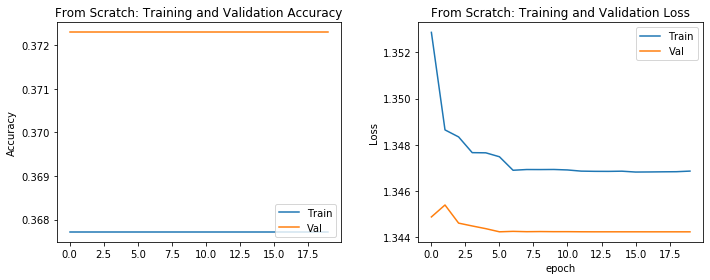

In [196]:
acc = model_scratch.history.history['accuracy']
val_acc = model_scratch.history.history['val_accuracy']

loss = model_scratch.history.history['loss']
val_loss = model_scratch.history.history['val_loss']

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([0,max(plt.ylim())])
plt.title('From Scratch: Training and Validation Accuracy')

plt.subplot(1,2, 2)
plt.plot(loss, label='Train')
plt.plot(val_loss, label='Val')
plt.legend(loc='upper right')
plt.ylabel('Loss')
#plt.ylim([0,5.0])
plt.title('From Scratch: Training and Validation Loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

### 2. InceptionResnet: fine-tuning

In [197]:
# Compile, Train, and Test
model_in.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics = ['accuracy'])
model_in.fit(training_set, epochs = 20, validation_data = val_set, callbacks=[callback], verbose=0)
# Save the model 
model_in.save_weights("model_in.h5")

model_in.evaluate(test_set)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
15/15 [==============================] - 2s 150ms/step - loss: 0.5047 - accuracy: 0.8889


[0.5047271208837628, 0.8888889]

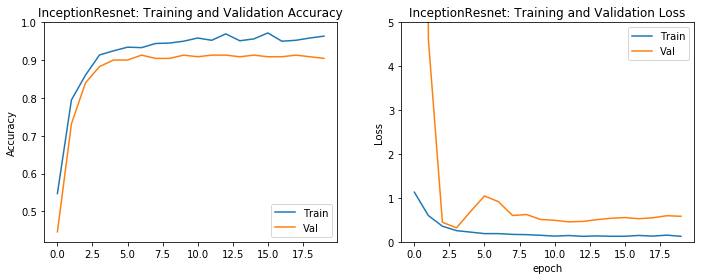

In [203]:
acc = model_in.history.history['accuracy']
val_acc = model_in.history.history['val_accuracy']

loss = model_in.history.history['loss']
val_loss = model_in.history.history['val_loss']

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('InceptionResnet: Training and Validation Accuracy')

plt.subplot(1,2, 2)
plt.plot(loss, label='Train')
plt.plot(val_loss, label='Val')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,5.0])
plt.title('InceptionResnet: Training and Validation Loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

### 3. Resnet50: fine-tuning 

In [205]:
# Compile, Train, and Test
model_res.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics = ['accuracy'])
model_res.fit(training_set, epochs = 20, validation_data = val_set, callbacks=[callback], verbose=0)
 
model_res.save_weights("model_res.h5")

# Test the model 
model_res.evaluate(test_set)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
15/15 [==============================] - 2s 148ms/step - loss: 1.3054 - accuracy: 0.4530


[1.305402366320292, 0.45299146]

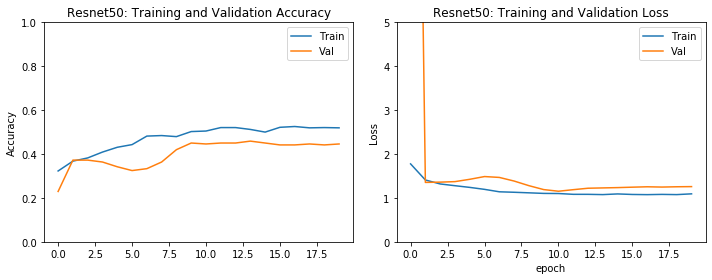

In [206]:
acc = model_res.history.history['accuracy']
val_acc = model_res.history.history['val_accuracy']

loss = model_res.history.history['loss']
val_loss = model_res.history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend()
plt.ylabel('Accuracy')
plt.ylim([0,1.0])
plt.ylim([min(plt.ylim()),1])
plt.title('Resnet50: Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train')
plt.plot(val_loss, label='Val')
plt.legend()
plt.ylabel('Loss')
plt.ylim([0,5.0])
plt.title('Resnet50: Training and Validation Loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()


### 4: InceptionV3: fine-tuning


In [201]:
# Compile, Train, and Test
model_inv3.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics = ['accuracy'])
model_inv3.fit(training_set, epochs = 20, validation_data = val_set, callbacks=[callback], verbose=0)
 
model_inv3.save_weights("model_inv3.h5")

# Test the model 
model_inv3.evaluate(test_set)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
15/15 [==============================] - 3s 188ms/step - loss: 0.8612 - accuracy: 0.5983


[0.8612273236115774, 0.5982906]

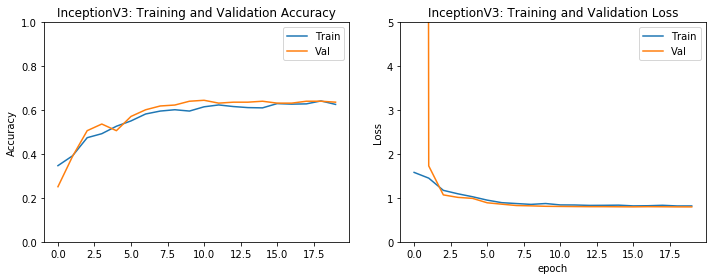

In [204]:
acc = model_inv3.history.history['accuracy']
val_acc = model_inv3.history.history['val_accuracy']

loss = model_inv3.history.history['loss']
val_loss = model_inv3.history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend()
plt.ylabel('Accuracy')
plt.ylim([0,1.0])
plt.ylim([min(plt.ylim()),1])
plt.title('InceptionV3: Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train')
plt.plot(val_loss, label='Val')
plt.legend()
plt.ylabel('Loss')
plt.ylim([0,5.0])
plt.title('InceptionV3: Training and Validation Loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()
